# Physics 256
## Metropolis Monte Carlo

<img src='https://c.o0bg.com/rf/image_960w/Boston/2011-2020/2015/06/03/BostonGlobe.com/Arts/Images/24w.jpg', width=600px>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

#%matplotlib inline
#plt.style.use('notebook');
#%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

### Ising Model of Ferromagnatism

Measuring energies in units where $J=k_{\rm B} = 1$ we can write the Ising model Hamiltonian:

\begin{equation}
H = - \sum_{\langle i,j\rangle } \sigma_i \sigma_j
\end{equation}

where $\sigma_i = \pm 1$ and $\langle i,j \rangle$ means that sites $i$ and $j$ are nearest neighbors.  Let's consider a $N = L \times L$ square lattice in $d=2$ with periodic boundary conditions.  This is equivalent to wrapping our lattice onto the surface of a torus.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Torus_from_rectangle.gif" width=400px>

In two dimensions, our *spin* array $\sigma_i$ can be written as a matrix:

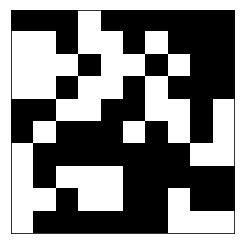

In [2]:
def initialize_config(L):
    '''Initialize a random spin configuration'''

    σ = np.ones([L,L],dtype=int)
    σ[np.random.random([L,L])<=0.5] = -1
    return σ


L = 10
σ = initialize_config(L)

# visualize
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
plt.show()

In terms of this matrix, the energy can be written as:

\begin{equation}
E = - \frac{1}{2}\sum_{i=0}^{L-1} \sum_{j=0}^{L-1} \sigma[i,j]\left(\sigma[i+1,j] + \sigma[i-1,j] + \sigma[i,j+1] + \sigma[i,j-1]\right)
\end{equation}

How do we deal with the periodic boundary conditions?

In [3]:
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)
m1[0] = L-1

print(p1)
print(m1)

[1 2 3 4 5 6 7 8 9 0]
[9 0 1 2 3 4 5 6 7 8]


<div class="span alert alert-success">
<h2> Programming challenge </h2>
Complete the function that computes the energy $E$ and magnetization $M$ of a 2d Ising model.
</div>

<!--
    for i in range(σ.shape[0]):
        for j in range(σ.shape[1]):
            cE -= σ[i,j] * (σ[p1[i],j] + σ[m1[i],j] + σ[i,p1[j]] + σ[i,m1[j]])
-->

In [4]:
def get_props(σ):
    '''The energy E and magnetization M for a microstate of the 2d Ising model.'''
    E,M = 0,0
    for i in range(σ.shape[0]):
        for j in range(σ.shape[1]):
            M += σ[i,j]
            E -= 0.5*σ[i,j]*(σ[p1[i],j] + σ[m1[i],j] + σ[i,p1[j]] + σ[i,m1[j]])
    return E,M

In [5]:
get_props(σ)

(-8.0, -16)

## Monte Carlo Update

An update consists of flipping an individual spin and we need to determine the change in energy.  Suppose we flip the spin with index $k,\ell$, then: $\sigma'[k,\ell] = -\sigma[k,\ell]$ and we can write:

\begin{align*}
\Delta E &= E' - E \newline
&= 2\sigma[k,\ell]\left(\sigma[k+1,\ell] + \sigma[k-1,\ell] + \sigma[k,\ell+1] + \sigma[k,\ell-1]\right).
\end{align*}

and 

\begin{equation}
\Delta M = 2 \sigma[k,\ell]
\end{equation}

and thus the acceptance probability for the move will be:

\begin{equation}
P_{\rm acc} = \mathrm{e}^{-\Delta E/T}.
\end{equation}

Each Monte Carlo update consists of:

1. Select a random spin to flip with equal probability
2. Calculate $\Delta E$
3. Generate a uniform random number $r \in \mathcal{U}_{[0,1)}$
4. Perform the Metropolis test
    - If $r < \mathrm{e}^{-\Delta E/T}$: accept the move
    - Otherwise: do nothing
5. Measure the magnetization

A Monte Carlo **step** consists of $N=L^2$ updates.

In [6]:
def monte_carlo_step(σ,T):
    '''Perform a Monte Carlo step.'''
    
    # get the current magnetization
    M = np.sum(σ)
    
    # attempt L^2 spin flips
    for update in range(σ.size):
        
        # get the random spin
        k = np.random.randint(0,σ.shape[0])
        ℓ = np.random.randint(0,σ.shape[1])
        
        # calculate the change in energy
        ΔE = 2*σ[k,ℓ]*(σ[p1[k],ℓ] + σ[m1[k],ℓ] + σ[k,p1[ℓ]] + σ[k,m1[ℓ]])
        
        # perform the Metropolis test
        if np.random.random() <= np.exp(-ΔE/T):
            σ[k,ℓ] *= -1

            # Update the magnetization
            M += 2*σ[k,ℓ]
    
    return M

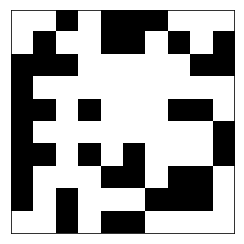

In [7]:
σ = initialize_config(L)
# visualize
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
get_props(σ)
plt.show()

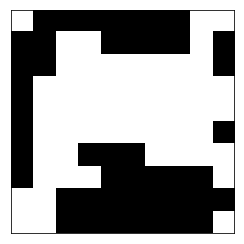

In [8]:
monte_carlo_step(σ,0.1)
plt.matshow(σ, cmap='gray', extent=[0,9,0,9]);
plt.xticks([]);
plt.yticks([]);
get_props(σ)
plt.show()

### Monte Carlo Simulation

A simulation consists of performing a large number of Monte Carlo steps at each temperature starting from some random initial configuration.

In [9]:
# temperatures to consider
T = np.arange(0.2,2.5,0.2)
T = np.arange(2.6,2.91,0.2)
# number of Monte Carlo steps we will perform
num_steps = 2**16

# magnetization for each temperature
M = np.zeros([num_steps,T.size])

In [10]:
# initialize
L = 5
σ = initialize_config(L)

# create PBC lookup tables
p1 = np.arange(1,L+1)
p1[-1] = 0
m1 = np.arange(-1,L-1)
m1[0] - L-1

# Loop over temperatures from high to low
for iT,cT in enumerate(T[::-1]):
    m = T.size - 1 - iT
    
    # initialize the magnetization
    M[0,m] = np.sum(σ)
    
    # Perform the Monte Carlo steps
    for step in range(1,num_steps):
        M[step,m] = monte_carlo_step(σ,cT)

## Observing the  results

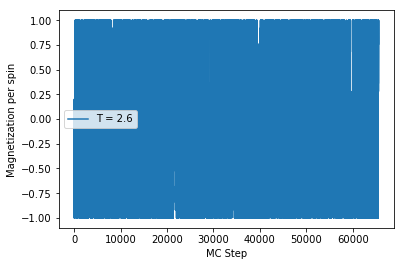

In [11]:
iT = 0
#print(T[iT])
plt.plot(M[:,iT]/L**2,'-', label='T = %3.1f' %T[iT])
plt.legend()
plt.xlabel('MC Step')
plt.ylabel('Magnetization per spin')
plt.show()

In [12]:
T

array([2.6, 2.8])

## Analyzing the results

We want to compute the average value at each temperature, but we need to skip some number of initial measurements as the system takes some *time* to equilibrate.

In [13]:
#np.savetxt('/Users/agdelma/Documents/UVM/Talks/2018/CompManyBody.06/Notebooks/mc_data.txt',M[:,iT]/L**2)

In [14]:
skip = 2000
m = np.average(M[skip:]/L**2,axis=0)
δm = np.std(M[skip:]/L**2,axis=0)/np.sqrt(num_steps-skip)

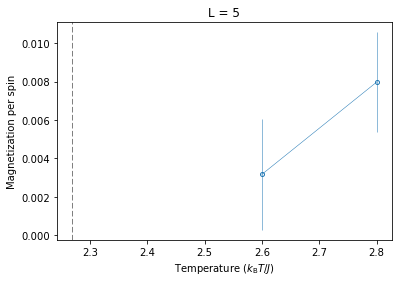

In [15]:
plt.errorbar(T,np.abs(m),yerr=δm, linewidth=0.5, marker='o', markerfacecolor='None', markeredgecolor=colors[0], markersize=4, elinewidth=0.5)
plt.axvline(x=2.0/np.log(1.0+np.sqrt(2.0)), linewidth=1, color='gray', linestyle='--')
#plt.xlim(0.2,2.4)
#plt.ylim(-0.01,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 5")
plt.show()

## Load some data for a *much* longer run and $L=32$ from disk and compare with the exact Onsager solution

\begin{equation}
M=\left(1-\left[\sinh \frac{2J}{k_{\rm B}T}\right]^{-4}\right)^{\frac {1}{8}}
\end{equation}

In [16]:
def magnetization_exact_(T):
    '''We use units where J/k_B = 1.'''
    Tc = 2.0/np.log(1.0+np.sqrt(2.0))
    if T < Tc:
        return (1.0 - np.sinh(2.0/T)**(-4))**(1.0/8)
    else:
        return 0.0
magnetization_exact = np.vectorize(magnetization_exact_)

In [17]:
data = np.loadtxt('data/Ising_estimators_032.dat')
lT = np.linspace(0.01,4,1000)
lL = 32

plt.plot(lT,magnetization_exact(lT),'-k', linewidth=1, label='Exact')
plt.errorbar(data[:,0],np.abs(data[:,5])/lL**2,yerr=data[:,6]/lL**2, linewidth=0.5, marker='o', markerfacecolor='None', 
             markeredgecolor=colors[0], markersize=4, elinewidth=0.5, label='Monte Carlo')
plt.xlim(0.2,4)
plt.ylim(0,1.1)
plt.xlabel(r'Temperature ($k_{\rm B}T/J$)')
plt.ylabel('Magnetization per spin')
plt.title("L = 32")
plt.legend()